In [1]:
!pip install transformers evaluate sentencepiece nltk rouge-score
!git clone https://github.com/ChaitaliV/generative-explanation;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=71ff982613fe28eb8521a3f84b4debc0be1a3197335f777408518654a5b76316
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Cloning into 'generative-explanation'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 167 (delta 39), reused 3 (delta 3), pack-reused 96
Receiving ob

In [2]:
import torch
import requests
import json
import pandas as pd
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import evaluate
from datasets import load_metric
import numpy as np
import nltk
import matplotlib.pyplot as plt

## Get Data

In [4]:
df = pd.read_csv('generative-explanation/datasets/supervised_data.csv')

df = df.dropna()

# Define replacements
replacement_dict = {
    'i': 'The sentence does not show any depression symptoms or stress',
    'w/f': 'Patient has stressfule environment around them, which might contribute to higher stress and depression',
    'h': 'Pateint has history of depression and/or has taken mediction for the same',
    'c': 'Patient might have depression, but the context is required for proper diagnosis'
}

# Replace values in the 'column_name' column using replace()
df['explanation'] = df['explanation'].replace(replacement_dict)

r2 = {
    0.0 : 'Non-Depression',
    1.0 : 'Depression',
    2.0 : 'Grey-Area'
}
df['label'] = df['label'].replace(r2)

df

,Unnamed: 0,text,label,explanation
0,0,"I run the machine for the jeans etc., which ar...",Non-Depression,The sentence does not show any depression symp...
1,1,"Apart from this, sir, after doing normal work ...",Non-Depression,The sentence does not show any depression symp...
2,2,"Sir, income is work in contract, Sir what happ...",Non-Depression,The sentence does not show any depression symp...
3,3,Almost in a month - there is work according to...,Non-Depression,The sentence does not show any depression symp...
4,4,my name is Sonu.,Non-Depression,The sentence does not show any depression symp...
...,...,...,...,...
2000,2000,We will be married for 36 years,Non-Depression,The sentence does not show any depression symp...
2001,2001,"Since January 31st, I am here.",Non-Depression,The sentence does not show any depression symp...
2002,2002,"There is a daughter at home, a son, married he...",Non-Depression,The sentence does not show any depression symp...
2003,2003,Will turn 12 on January 19.,Non-Depression,The sentence does not show any depression symp...


## Initialization

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
tokenizer = T5TokenizerFast.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base", return_dict=True)
device = 'cuda:0'
pattern_len = 218
response_len = 218
batch_size = 4
epochs = 5
optimizer = AdamW(model.parameters(), lr=0.0001)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Prepare Data
* load the dataset
* since it is seq2seq model pre-training, I used T5 tokenizer and created, input_ids and attention masks for encoder, and used labels for decoder(labels are basically input_ids of tokenized target text, I didn't use attention_mask of decoder due to GPU running out of memory during training, but labels are capable of getting decoder attention_masks for T5 model while training so it's okay.)
* Then I created train-test split on the data, with 0.1 data used for validation, since the dataset is small, I am not taking out "test" data, coz focus is on training method, rather than checking final accuracy on test data.
* created dataloaders for both training data and validation data

In [9]:
class Prepare_Data():
  """
  this class will take the dataframe and,
  -- tokenize the text, get input_ids, attention_masks, and labels
  -- make train-validation split
  -- create dataloaders for training and validation data
  """
  def __init__(self, tokenizer, dframe, q_len, t_len):
    self.tokenizer = tokenizer
    self.p_len = pattern_len
    self.r_len = response_len
    self.data = dframe
    self.sentences = self.data.text.values
    self.responses = self.data.explanation.values
    self.tags = self.data.label.values

  def prepare_dataloader(self):
    # tokenize pattern + tag (as input features- encoder)
    pattern_tokenized = self.tokenizer([str(tag) for tag in self.tags],[str(sequence) for sequence in self.sentences], max_length=self.p_len, padding="max_length",
                                                    truncation=True, pad_to_max_length=True, add_special_tokens=True,return_tensors="pt")

    # tokenize target response(as target - decoder)
    response_tokenized = self.tokenizer([str(response) for response in self.responses], max_length=self.r_len, padding="max_length",
                                          truncation=True, pad_to_max_length=True, add_special_tokens=True, return_tensors = "pt")


    ## get labels, input_ids, and attention_mask
    labels = response_tokenized.input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    input_ids = pattern_tokenized.input_ids
    attention_mask = pattern_tokenized.attention_mask

    #create train, validation split
    train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,random_state = 2018, test_size = 0.1 )
    train_masks, validation_masks, _, _ = train_test_split(attention_mask, input_ids,
                                             random_state=2018, test_size=0.1)

    #create dataloaders for training and validation data
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    return train_dataloader, validation_dataloader

In [10]:
LoadData = Prepare_Data(tokenizer, df, pattern_len, response_len)
train_dataloader, validation_dataloader = LoadData.prepare_dataloader()

## Train the Model
* used Adam optmizer for this task
* trained the model on training dataset, and then evaluated it in validation dataset

In [11]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [12]:
# The Training Loop
t = []
# Store our loss and accuracy for plotting
train_loss_set = []
val_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  #set model in training mode
  model.train()

  #tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    #forward pass
    outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    #backward pass
    loss.backward()
    #update parameters and take a step using the computed gradient
    optimizer.step()

    #update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  train_loss = tr_loss/nb_tr_steps
  train_loss_set.append(train_loss)

  print("Train loss: {}".format(train_loss))


  # Evaluation

  #put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  #tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  #evaluate data for one epoch
  for batch in validation_dataloader:
    #add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    #unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    #telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    e_loss = outputs['loss']

    #calculate loss for the whole batch
    eval_loss += e_loss.item()
    nb_eval_steps += 1

  val_loss = eval_loss/nb_eval_steps
  val_loss_set.append(val_loss)

  print("Validation loss: {}".format(val_loss))


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.35240645932876186


Epoch:  20%|██        | 1/5 [03:34<14:18, 214.73s/it]

Validation loss: 0.09964004622368378
Train loss: 0.07769173978979672


Epoch:  40%|████      | 2/5 [07:12<10:50, 216.74s/it]

Validation loss: 0.09400910738364188
Train loss: 0.057189187976757414


Epoch:  60%|██████    | 3/5 [10:51<07:14, 217.48s/it]

Validation loss: 0.0830514877760584
Train loss: 0.04536873996337156


Epoch:  80%|████████  | 4/5 [14:29<03:37, 217.71s/it]

Validation loss: 0.08382534509326202
Train loss: 0.03688134748801708


Epoch: 100%|██████████| 5/5 [18:07<00:00, 217.48s/it]

Validation loss: 0.07769455700906078


In [13]:
len(val_loss_set)

5

[]

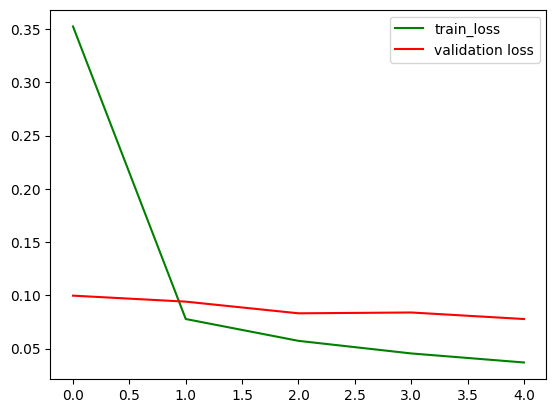

In [14]:
plt.plot(np.arange(0, len(train_loss_set)), train_loss_set, color = 'g', label = 'train_loss')
plt.plot(np.arange(0,len(val_loss_set)), val_loss_set, color = 'r', label = 'validation loss')
plt.legend()
plt.plot()

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
torch.save(model,r'/content/drive/MyDrive/T5_with_classification.pt')

## Make Inference


In [17]:
model = torch.load(r'/content/drive/MyDrive/T5_with_classification.pt')